In [1]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.sampling import BayesianModelSampling
import pandas as pd
from pgmpy.estimators import MaximumLikelihoodEstimator
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
from pgmpy.inference import VariableElimination
from sklearn.metrics import f1_score
from pomegranate import *
from ucimlrepo import fetch_ucirepo

#### Importar datos

In [2]:
 # fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
  
# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features 
y = predict_students_dropout_and_academic_success.data.targets 

data=pd.DataFrame.from_dict(predict_students_dropout_and_academic_success['data']['original'])
data

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


#### Tratamiento y transformacion de datos

In [3]:
#Tratamiento de los datos

#Eliminar todas las observaciones donde el Target sea 'Enrolled'
data_mod = data[data['Target'] != 'Enrolled']

#Categorizar variable Age of Enrollment
bins = [0, 19, 21, 24, 31, 41, float('inf')]  # Límites de los rangos
labels = ['Rango 16-18', 'Rango 19-20', 'Rango 21-23', 'Rango 24-30', 'Rango 31-40', 'Rango >41'] 
data_mod['age_range'] = pd.cut(data_mod['Age at enrollment'], bins=bins, labels=labels, right=False)

#Categorizar variable Curricular units 1st sem (approved)
bins = [0, 3, 6, 11, float('inf')]  # Límites de los rangos
labels = ['Rango 0-2', 'Rango 3-5', 'Rango 6-10', 'Rango >10'] 
data_mod['approved_sem1_range'] = pd.cut(data_mod['Curricular units 1st sem (approved)'], bins=bins, labels=labels, right=False)

#Categorizar variable Curricular units 1st sem (grade)
bins = [0, 10,11, 12,13, 14,16,float('inf')]  # Límites de los rangos
labels = ['Rango 0-10', 'Rango 10-11','Rango 11-12', 'Rango 12-13', 'Rango 13-14','Rango 14-16', 'Rango >16'] 
data_mod['grade_sem1_range'] = pd.cut(data_mod['Curricular units 1st sem (grade)'], bins=bins, labels=labels, right=False)

#Categorizar variable Admission grade
bins = [0, 100,115, 130,145, 160,float('inf')]  # Límites de los rangos
labels = ['Rango 0-100', 'Rango 100-115','Rango 115-130', 'Rango 130-145', 'Rango 145-160', 'Rango >160'] 
data_mod['grade_admission_range'] = pd.cut(data_mod['Admission grade'], bins=bins, labels=labels, right=False)

# Verifica el resultado
data_mod

C:\Users\mayer\AppData\Local\Temp/ipykernel_14328/3463301911.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mod['age_range'] = pd.cut(data_mod['Age at enrollment'], bins=bins, labels=labels, right=False)
C:\Users\mayer\AppData\Local\Temp/ipykernel_14328/3463301911.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mod['approved_sem1_range'] = pd.cut(data_mod['Curricular units 1st sem (approved)'], bins=bins, labels=labels, right=False)
C:\Users\mayer\AppData\Local\Temp/ipykernel_14328/34633

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,age_range,approved_sem1_range,grade_sem1_range,grade_admission_range
0,1,17,5,171,1,1,122.0,1,19,12,...,0.000000,0,10.8,1.4,1.74,Dropout,Rango 19-20,Rango 0-2,Rango 0-10,Rango 115-130
1,1,15,1,9254,1,1,160.0,1,1,3,...,13.666667,0,13.9,-0.3,0.79,Graduate,Rango 19-20,Rango 6-10,Rango 14-16,Rango 130-145
2,1,1,5,9070,1,1,122.0,1,37,37,...,0.000000,0,10.8,1.4,1.74,Dropout,Rango 19-20,Rango 0-2,Rango 0-10,Rango 115-130
3,1,17,2,9773,1,1,122.0,1,38,37,...,12.400000,0,9.4,-0.8,-3.12,Graduate,Rango 19-20,Rango 6-10,Rango 13-14,Rango 115-130
4,2,39,1,8014,0,1,100.0,1,37,38,...,13.000000,0,13.9,-0.3,0.79,Graduate,Rango >41,Rango 3-5,Rango 12-13,Rango 130-145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,12.666667,0,15.5,2.8,-4.06,Graduate,Rango 19-20,Rango 3-5,Rango 13-14,Rango 115-130
4420,1,1,2,9773,1,1,120.0,105,1,1,...,11.000000,0,11.1,0.6,2.02,Dropout,Rango 16-18,Rango 6-10,Rango 12-13,Rango 115-130
4421,1,1,1,9500,1,1,154.0,1,37,37,...,13.500000,0,13.9,-0.3,0.79,Dropout,Rango 24-30,Rango 6-10,Rango 14-16,Rango 145-160
4422,1,1,1,9147,1,1,180.0,1,37,37,...,12.000000,0,9.4,-0.8,-3.12,Graduate,Rango 19-20,Rango 3-5,Rango 13-14,Rango 145-160


#### Crear modelo de red bayesiana y ajustar mediante Maxima Verosimilitud

In [4]:
# Definir una semilla
random.seed(12232)

# Definimos el modelo como una red bayesiana con los arcos

#Accurrency 0.80 
model = BayesianNetwork([("Gender", "Target"),("Displaced","Target"),
                         ("Scholarship holder","Target"),("Debtor","Target"),("Tuition fees up to date","Target"),
                         ("age_range","Target"),("approved_sem1_range","Target"),("grade_sem1_range","Target")]) 
#Accurrency 0.81
model = BayesianNetwork([("Gender", "Target"),("Displaced","Target"),
                         ("Scholarship holder","Target"),("Debtor","Target"),("Tuition fees up to date","Target"),
                         ("age_range","Target"),("grade_sem1_range","Target")])

#Accurrency 0.82
model = BayesianNetwork([("Gender", "Target"),("Displaced","Target"),
                         ("Scholarship holder","Target"),("Debtor","Target"),("Tuition fees up to date","Target"),
                         ("age_range","Target"),("approved_sem1_range","Target"),("grade_admission_range","Target")])

#Accurrency 0.84
model = BayesianNetwork([("Gender", "Target"),("Displaced","Target"),
                         ("Scholarship holder","Target"),("Debtor","Target"),("Tuition fees up to date","Target"),
                         ("age_range","Target"),("approved_sem1_range","Target")])

#Modelo con enlace: Accurrency 0.84 al colocar todas las variables, Accurrency 0.74 al no colocar variable intermedia
model = BayesianNetwork([("Gender", "Target"),("Displaced","Target"),
                         ("Scholarship holder","Target"),("Debtor","Target"),("Tuition fees up to date","Target"),
                         ("age_range","Target"),("approved_sem1_range","Target"),("grade_admission_range","approved_sem1_range")])


In [5]:
variables_seleccionadas = ['Gender', 'Displaced', 'Scholarship holder', 'Debtor',
                           'Tuition fees up to date','age_range','approved_sem1_range','grade_sem1_range','Target']

variables_seleccionadas = ['Gender', 'Displaced', 'Scholarship holder', 'Debtor',
                           'Tuition fees up to date','age_range','grade_sem1_range','Target']

variables_seleccionadas = ['Gender', 'Displaced', 'Scholarship holder', 'Debtor',
                           'Tuition fees up to date','age_range','approved_sem1_range','grade_admission_range','Target']

variables_seleccionadas = ['Gender', 'Displaced', 'Scholarship holder', 'Debtor',
                           'Tuition fees up to date','age_range','approved_sem1_range','Target']

variables_seleccionadas = ['Gender', 'Displaced', 'Scholarship holder', 'Debtor',
                           'Tuition fees up to date','age_range','approved_sem1_range','grade_admission_range','Target']



data_sel = data_mod[variables_seleccionadas]
data_sel

,Gender,Displaced,Scholarship holder,Debtor,Tuition fees up to date,age_range,approved_sem1_range,grade_admission_range,Target
0,1,1,0,0,1,Rango 19-20,Rango 0-2,Rango 115-130,Dropout
1,1,1,0,0,0,Rango 19-20,Rango 6-10,Rango 130-145,Graduate
2,1,1,0,0,0,Rango 19-20,Rango 0-2,Rango 115-130,Dropout
3,0,1,0,0,1,Rango 19-20,Rango 6-10,Rango 115-130,Graduate
4,0,0,0,0,1,Rango >41,Rango 3-5,Rango 130-145,Graduate
...,...,...,...,...,...,...,...,...,...
4419,1,0,0,0,1,Rango 19-20,Rango 3-5,Rango 115-130,Graduate
4420,0,1,0,1,0,Rango 16-18,Rango 6-10,Rango 115-130,Dropout
4421,0,1,1,0,1,Rango 24-30,Rango 6-10,Rango 145-160,Dropout
4422,0,1,1,0,1,Rango 19-20,Rango 3-5,Rango 145-160,Graduate


In [6]:
#Dividir el dataset entre prueba y entrenamiento
train, test = train_test_split(data_sel, test_size=0.2, random_state=98)

In [7]:
#Calcular los parametros> probabilidades condicionales mediante maxima verosimilitud

emv = MaximumLikelihoodEstimator(model=model, data=train)

model.fit(data=train, estimator = MaximumLikelihoodEstimator) 
for i in model.nodes():
    print(model.get_cpds(i)) 

#Chequiar modelo
model.check_model()

+-----------+----------+
| Gender(0) | 0.651171 |
+-----------+----------+
| Gender(1) | 0.348829 |
+-----------+----------+
+-------------------------+-----+--------------------------------+
| Debtor                  | ... | Debtor(1)                      |
+-------------------------+-----+--------------------------------+
| Displaced               | ... | Displaced(1)                   |
+-------------------------+-----+--------------------------------+
| Gender                  | ... | Gender(1)                      |
+-------------------------+-----+--------------------------------+
| Scholarship holder      | ... | Scholarship holder(1)          |
+-------------------------+-----+--------------------------------+
| Tuition fees up to date | ... | Tuition fees up to date(1)     |
+-------------------------+-----+--------------------------------+
| age_range               | ... | age_range(Rango >41)           |
+-------------------------+-----+--------------------------------+
| ap

True

#### Evaluar el modelo con datos de prueba: predecir Target

In [16]:
#Evaluacion del modelo para predecir la variable Target

testVariableTarget = test['Target']
testVariableTarget.head()
testVariableTarget.value_counts()

testVariables = test.drop(columns=['Target'])
testVariables = test.drop(columns=['Target','approved_sem1_range']) #En caso del modelo con arco adicional
testVariables.head()

prediccion=model.predict(testVariables) #Prediccion del modelo
prediccion.head() #Imprimir prediccion
prediccion.value_counts()
prediccion['Target'].value_counts()

  0%|          | 0/256 [00:00<?, ?it/s]

Graduate    554
Dropout     172
Name: Target, dtype: int64

In [17]:
#Exactitud de la prediccion
accuracy_score(y_true=testVariableTarget, y_pred=prediccion['Target'])

0.7451790633608816

[[131 144]
 [ 41 410]]


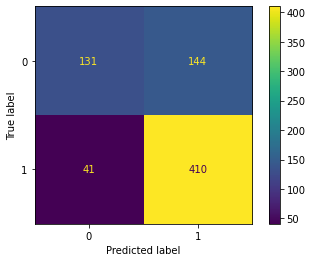

In [18]:
#Reportar falsos positivos, ...
cm=confusion_matrix(y_true=testVariableTarget, y_pred=prediccion['Target'])
print(confusion_matrix(y_true=testVariableTarget, y_pred=prediccion['Target']))

from sklearn.metrics import  ConfusionMatrixDisplay

confusion_matrix(y_true=testVariableTarget, y_pred=prediccion['Target'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [19]:
#F1 score
f1_score(testVariableTarget, prediccion['Target'], average=None)
f1_score(testVariableTarget, prediccion['Target'], average='micro')

0.7451790633608816

#### Obtener Probabilidades dado un Individuo Particular

In [62]:
dataIndividual= {'Gender': 1, 
               'Displaced': 1,
               'Scholarship holder': 0,
               'Debtor': 0,
               'Tuition fees up to date': 1,
               'age_range': 'Rango 24-30',
               'approved_sem1_range': 'Rango 6-10',
               'grade_admission_range': 'Rango 115-130'}

dataIndividual= {'Gender': 1, 
               'Displaced': 1,
               'Scholarship holder': 0,
               'Debtor': 0,
               'Tuition fees up to date': 1,
               'age_range': 'Rango 24-30',
               'grade_admission_range': 'Rango 115-130'}

dataIndividual2 = pd.DataFrame([dataIndividual])
dataIndividual2

,Gender,Displaced,Scholarship holder,Debtor,Tuition fees up to date,age_range,grade_admission_range
0,1,1,0,0,1,Rango 24-30,Rango 115-130


In [64]:
# Opcion 1: Utilizamos la clase VariableElimination para estimar

# Creamos un objeto de tipo VariableElimination
infer = VariableElimination(model)

caso = infer.query(["Target"], evidence=dataIndividual)
print(caso)

+------------------+---------------+
| Target           |   phi(Target) |
+==================+===============+
| Target(Dropout)  |        0.6089 |
+------------------+---------------+
| Target(Graduate) |        0.3911 |
+------------------+---------------+


In [65]:
#Opcion 2: utilizando el metodo predict_probability
model.predict_probability(dataIndividual2)

,Target_Dropout,Target_Graduate,approved_sem1_range_Rango 0-2,approved_sem1_range_Rango 3-5,approved_sem1_range_Rango 6-10,approved_sem1_range_Rango >10
0,0.608854,0.391146,0.211585,0.275141,0.479485,0.033789


#### Ideas Dash

#Interfaz
Enfocada en la univerdidad

#Input: Formulario 
-Variables: posibilidad de ingresar todas las variables del modelo (en caso de las variables directas)
-Variables adicionales de relleno> nombre, fecha nacimiento, signo zodiacal jeje, ...


#Output: 
-Probabilidad de Dropout y Graduate: barras o piechart
-Recomendacion a la universidad dado unos rangos de riesgos

Exactitud y confiabilidad del modelo:
-confusion_matrix
-accuracy_score
-f1 score
